In [39]:
import numpy as np
import pandas as pd
import xarray as xr
from joblib import dump, load
from sklearn.model_selection import train_test_split
import math as mt
from math import e
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#Input

In [10]:
# Read Orography
OroData = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5IGP_Orography.nc')

In [11]:
#Surface data
t2mData = xr.open_dataset('../../../Data/CMIP6/GFDL-ESM4/NDJF/tasNHRegrid_NDJFday_GFDL-CM4_historical_r1i1p1f1_gr2_18500101-20141231.nc')
rhData  = xr.open_dataset('../../../Data/CMIP6/GFDL-ESM4/NDJF/hursNHRegrid_NDJFday_GFDL-CM4_historical_r1i1p1f1_gr2_18500101-20141231.nc')
u10Data = xr.open_dataset('../../../Data/CMIP6/GFDL-ESM4/NDJF/uasNHRegrid_NDJFday_GFDL-CM4_historical_r1i1p1f1_gr2_18500101-20141231.nc')
v10Data = xr.open_dataset('../../../Data/CMIP6/GFDL-ESM4/NDJF/vasNHRegrid_NDJFday_GFDL-CM4_historical_r1i1p1f1_gr2_18500101-20141231.nc')


In [19]:
# Level Data
tLevData = xr.open_dataset('../../../Data/CMIP6/GFDL-ESM4/NDJF/taNHRegrid_NDJFday_GFDL-CM4_historical_r1i1p1f1_gr2_18500101-20141231.nc')
zLevData = xr.open_dataset('../../../Data/CMIP6/GFDL-ESM4/NDJF/zgNHRegrid_NDJFday_GFDL-CM4_historical_r1i1p1f1_gr2_18500101-20141231.nc')
wLevData = xr.open_dataset('../../../Data/CMIP6/GFDL-ESM4/NDJF/wapNHRegrid_NDJFday_GFDL-CM4_historical_r1i1p1f1_gr2_18500101-20141231.nc')
uLevData = xr.open_dataset('../../../Data/CMIP6/GFDL-ESM4/NDJF/uaNHRegrid_NDJFday_GFDL-CM4_historical_r1i1p1f1_gr2_18500101-20141231.nc')

In [21]:
t2mD = t2mData.sel(latitude=slice(32,24),longitude=slice(74,86))
u10D = u10Data.sel(latitude=slice(32,24),longitude=slice(74,86))
v10D = v10Data.sel(latitude=slice(32,24),longitude=slice(74,86))
rhmD = rhData.sel(latitude=slice(32,24),longitude=slice(74,86))
tLevD = tLevData.sel(latitude=slice(32,24),longitude=slice(74,86))
zLevD = zLevData.sel(latitude=slice(32,24),longitude=slice(74,86))
wLevD = wLevData.sel(latitude=slice(32,24),longitude=slice(74,86))
OroD = OroData.sel(latitude=slice(32,24),longitude=slice(74,86))
uLevD=uLevData.sel(latitude=slice(32,24),longitude=slice(74,86))

In [34]:
zLevD.zg.sel(plev=85000)

<xarray.DataArray 'zg' (time: 19800, latitude: 5, longitude: 7)>
[693000 values with dtype=float32]
Coordinates:
  * time       (time) object 1850-01-01 12:00:00 ... 2014-12-31 12:00:00
  * longitude  (longitude) float32 74.0 76.0 78.0 80.0 82.0 84.0 86.0
  * latitude   (latitude) float32 32.0 30.0 28.0 26.0 24.0
    plev       float64 8.5e+04
Attributes:
    standard_name:  geopotential_height
    long_name:      Geopotential Height
    units:          m
    cell_methods:   time: mean
    cell_measures:  area: areacella
    interp_method:  conserve_order2
    original_name:  zg

In [24]:
# Calculate wind speed and relative humidity
ws = ((v10D.vas.values**2)+(u10D.uas.values**2))**0.5
ws_ds = xr.Dataset({'ws': (('time','latitude','longitude'), ws)}, coords={'time': v10D.time,'latitude': v10D.latitude,'longitude': v10D.longitude})

In [25]:
rh_ds = xr.Dataset({'rh': (('time','latitude','longitude'), rhmD.hurs)}, coords={'time': v10D.time,'latitude': v10D.latitude,'longitude': v10D.longitude})

In [32]:
uLevD.ua.sel(plev=85000)

<xarray.DataArray 'ua' (time: 19800, latitude: 5, longitude: 7)>
[693000 values with dtype=float32]
Coordinates:
  * time       (time) object 1850-01-01 12:00:00 ... 2014-12-31 12:00:00
  * longitude  (longitude) float32 74.0 76.0 78.0 80.0 82.0 84.0 86.0
  * latitude   (latitude) float32 32.0 30.0 28.0 26.0 24.0
    plev       float64 8.5e+04
Attributes:
    standard_name:  eastward_wind
    long_name:      Eastward Wind
    units:          m s-1
    cell_methods:   time: mean
    cell_measures:  area: areacella
    interp_method:  conserve_order2
    original_name:  ua

In [35]:
#Calculate inv
inv=t2mD.tas.values-tLevD.ta.sel(plev=85000).values
inv_ds = xr.Dataset({'inv': (('time','latitude','longitude'), inv)}, coords={'time': v10D.time,'latitude': v10D.latitude,'longitude': v10D.longitude})
inv_ds.attrs
inv_ds.attrs['units']='K'
inv_ds.attrs['long_name']='t2m - t850'
#u shear calculation
ushear=(uLevD.ua.sel(plev=85000).values-u10D.uas.values)/(zLevD.zg.sel(plev=85000).values) 
ushear_ds = xr.Dataset({'ushear': (('time','latitude','longitude'), ushear)}, coords={'time': v10D.time,'latitude': v10D.latitude,'longitude': v10D.longitude})
ushear_ds.attrs['units']='s-1'
ushear_ds.attrs['long_name']='(u10 - u850)/z850'

In [40]:
# Calculate AO - input std normal latitude wighted 1000mb z
SLPData = xr.open_dataset('../../../Data/CMIP6/GFDL-ESM4/NDJF/weighted1000Std.nc')
#SLPData = xr.open_dataset('../eraDown/ERA5_2degree_Down/DailyMean/weighted1000.nc')

SLPData.slp.values

t1=SLPData.slp.stack(z=("lat", "lon"))
# fit scaler on training data
SLP_PC =PCA().fit_transform(t1)
print(SLP_PC[:,0].shape)
AO_ds = xr.Dataset({'AO': (('time'), SLP_PC[:,0])}, coords={'time': SLPData.time})


norm = StandardScaler().fit(SLP_PC[:,0].values.reshape(-1, 1))
    # transform training data
aoX = norm.transform(SLP_PC[:,0].values.reshape(-1, 1))
aoX.shape

AO_ds = xr.Dataset({'AO': (('time'), aoX[:,0]*-1.0)}, coords={'time': SLPData.time})


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.24311945, -0.2356167 , -0.22831504, ..., -0.26948228,
         -0.26221198, -0.2546719 ],
        [-0.22307622, -0.21974581, -0.21421339, ..., -0.23277186,
         -0.2295942 , -0.2263607 ],
        [-0.14281146, -0.14220323, -0.1415934 , ..., -0.14461939,
         -0.14402023, -0.14341736]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.33331078, -0.35477993, -0.3581379 , ..., -

In [65]:
ztest=zLevData.zg.sel(plev=100000)[16000:,:,:]

In [66]:
ztest

<xarray.DataArray 'zg' (time: 3800, latitude: 46, longitude: 180)>
[31464000 values with dtype=float32]
Coordinates:
  * time       (time) object 1983-02-10 12:00:00 ... 2014-12-31 12:00:00
  * longitude  (longitude) float32 0.0 2.0 4.0 6.0 ... 352.0 354.0 356.0 358.0
  * latitude   (latitude) float32 90.0 88.0 86.0 84.0 82.0 ... 6.0 4.0 2.0 0.0
    plev       float64 1e+05
Attributes:
    standard_name:  geopotential_height
    long_name:      Geopotential Height
    units:          m
    cell_methods:   time: mean
    cell_measures:  area: areacella
    interp_method:  conserve_order2
    original_name:  zg

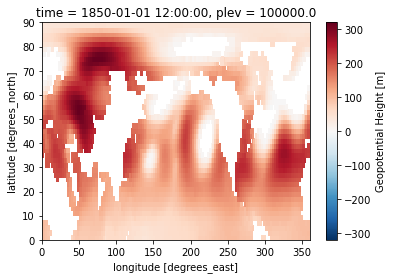

In [77]:
ZIn=xr.open_dataset('../../../Data/CMIP6/GFDL-ESM4/NDJF/zg_NDJFday_GFDL-CM4_historical_r1i1p1f1_gr2_18500101-20141231.nc')
ztest=ZIn.zg.sel(plev=100000,lat=slice(0,90))
ztest[0,:,:].plot(cmap='jet')

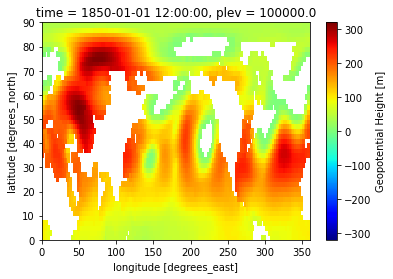

In [78]:
ztest[0,:,:].plot(cmap='jet')

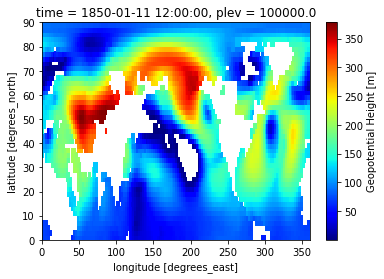

In [79]:
ztest[10,:,:].plot(cmap='jet')

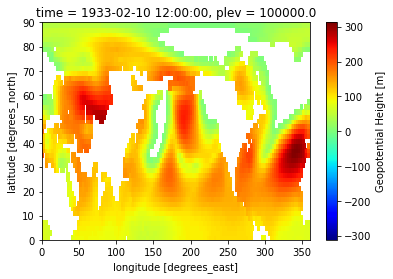

In [80]:
ztest[10000,:,:].plot(cmap='jet')

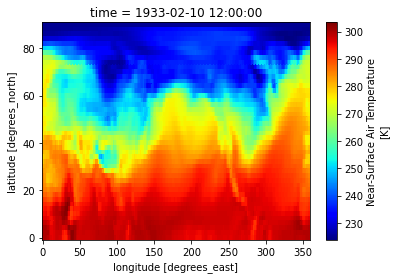

In [81]:
t2mData.tas[10000,:,:].plot(cmap='jet')

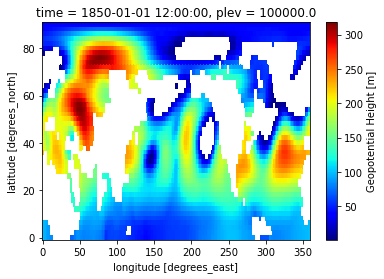

In [91]:
zLevData.zg[0,0,:,:].plot(cmap='jet')

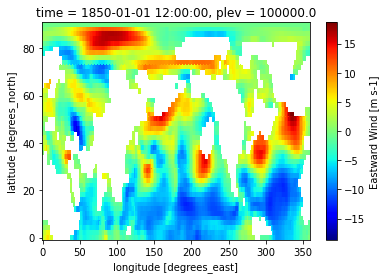

In [92]:
uLevData.ua[0,0,:,:].plot(cmap='jet')

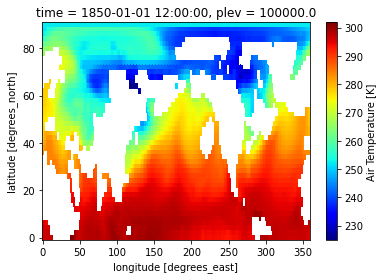

In [93]:
tLevData.ta[0,0,:,:].plot(cmap='jet')

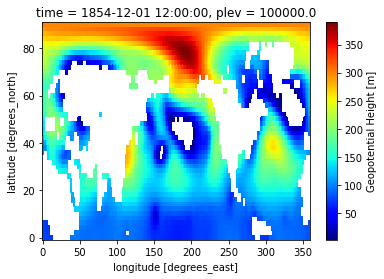

In [94]:
zLevData.zg[569,0,:,:].plot(cmap='jet')

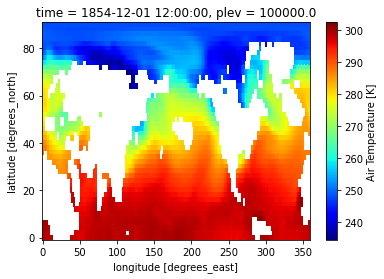

In [96]:
tLevData.ta[569,0,:,:].plot(cmap='jet')

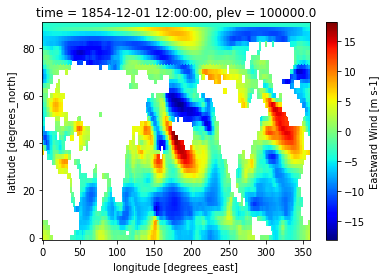

In [97]:
uLevData.ua[569,0,:,:].plot(cmap='jet')

In [64]:
ztest[190,10,:]

<xarray.DataArray 'zg' (longitude: 180)>
array([       nan,        nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,        nan,
              nan,   9.085389,  12.305705,  17.324055,  23.853218,  31.553396,
        39.085514,  47.358902,  55.917557,  64.18603 ,  72.45212 ,  78.44714 ,
        82.64735 ,  86.74393 ,  91.87435 ,  95.15787 ,  97.28215 ,  98.870094,
       100.05796 , 101.22792 , 104.3449  , 108.10767 , 114.203766, 121.73277 ,
       130.0137  , 142.52837 , 147.05493 ,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan, 195.9335  , 199.96086 , 203.28825 ,
       206.94348 , 209.60715 , 210.42381 , 212.87485 ,        nan,        nan,
              nan, 218.20728 , 221.29335 , 222.68274 , 224.60565 , 226.13632 ,
       226.34555 , 227.31203 , 229.70325 , 232.13972 , 234.23299 , 235.923   ,
       237.68634 , 239.42064 , 241.17924 , 242.88751 , 244.37337 , 245.08888 ,
       245.96452 , 246.57419 , 246.56888 , 246.1446  , 247.94054 , 249.71783 ,
       251.23611 , 251.73822 , 250.43173 , 246.52574 , 239.11438 , 230.22882 ,
       220.55057 , 210.67337 , 201.83798 , 192.8517  , 180.7724  , 167.66191 ,
       156.15776 , 146.4282  , 131.87186 , 121.75687 ,        nan,        nan,
              nan,        nan,  46.213696,  44.88904 ,  45.434002,  48.740635,
        49.821575,  52.2176  ,  54.269485,  54.138847,  54.176823,  51.85006 ,
        50.64929 ,  50.611877,        nan,        nan,        nan,        nan,
              nan,  90.42787 ,  95.691765,  98.8423  , 102.52081 , 104.79225 ,
       103.79874 , 102.17571 ,  98.890564,  94.95489 ,  91.466354,  88.392365,
        80.11208 ,  78.737915,  77.74055 ,  76.5727  ,  74.595245,  64.670845,
              nan,        nan,  65.43676 ,  67.1054  ,  67.73808 ,  65.59118 ,
        60.66164 ,  54.425217,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,        nan],
      dtype=float32)
Coordinates:
    time       object 1976-11-12 12:00:00
  * longitude  (longitude) float32 0.0 2.0 4.0 6.0 ... 352.0 354.0 356.0 358.0
    latitude   float32 70.0
    plev       float64 1e+05
Attributes:
    standard_name:  geopotential_height
    long_name:      Geopotential Height
    units:          m
    cell_methods:   time: mean
    cell_measures:  area: areacella
    interp_method:  conserve_order2
    original_name:  zg

In [61]:
ztest[:,:,0]

<xarray.DataArray 'zg' (time: 4800, latitude: 46)>
[220800 values with dtype=float32]
Coordinates:
  * time       (time) object 1975-01-01 12:00:00 ... 2014-12-31 12:00:00
    longitude  float32 0.0
  * latitude   (latitude) float32 90.0 88.0 86.0 84.0 82.0 ... 6.0 4.0 2.0 0.0
    plev       float64 1e+05
Attributes:
    standard_name:  geopotential_height
    long_name:      Geopotential Height
    units:          m
    cell_methods:   time: mean
    cell_measures:  area: areacella
    interp_method:  conserve_order2
    original_name:  zg